(2475764, 8)


,source_file,Timestamp,RPM,Speed_kmh,MAF_gps,dt_s,fuel_L_s,L_per_100km
0,2017-07-10_Seat_Leon_KA_KA_Stau.csv,2025-01-01 08:57:05.703,768.0,NaN,NaN,0.090,NaN,NaN
1,2017-07-10_Seat_Leon_KA_KA_Stau.csv,2025-01-01 08:57:05.793,768.0,0.0,NaN,0.090,NaN,NaN
2,2017-07-10_Seat_Leon_KA_KA_Stau.csv,2025-01-01 08:57:05.883,768.0,0.0,NaN,0.090,NaN,NaN
3,2017-07-10_Seat_Leon_KA_KA_Stau.csv,2025-01-01 08:57:05.971,768.0,0.0,7.22,0.088,0.010028,NaN
4,2017-07-10_Seat_Leon_KA_KA_Stau.csv,2025-01-01 08:57:06.062,768.0,0.0,7.22,0.091,0.010028,NaN


,Trip,Avg_Speed_kmh,Avg_RPM,Avg_Fuel_L/100km,HighRPM_LowSpeed_%,Long_Idle_%,Accel_Events,Brake_Events
0,2017-07-10_Seat_Leon_KA_KA_Stau.csv,14.455887,940.928115,0.472057,0.01,73.67,340,421
1,2017-07-11_Seat_Leon_KA_KA_Stau.csv,23.052541,1037.744883,0.414721,0.01,83.35,421,444
2,2017-07-11_Seat_Leon_KA_S_Normal.csv,68.238275,1583.488220,0.275587,0.01,89.80,1289,1180
3,2017-07-11_Seat_Leon_S_RT_Frei.csv,58.304813,1445.053577,0.268645,0.01,91.47,627,704
4,2017-07-12_Seat_Leon_RT_S_Normal.csv,52.877656,1416.844637,0.260331,0.00,89.32,1169,1172


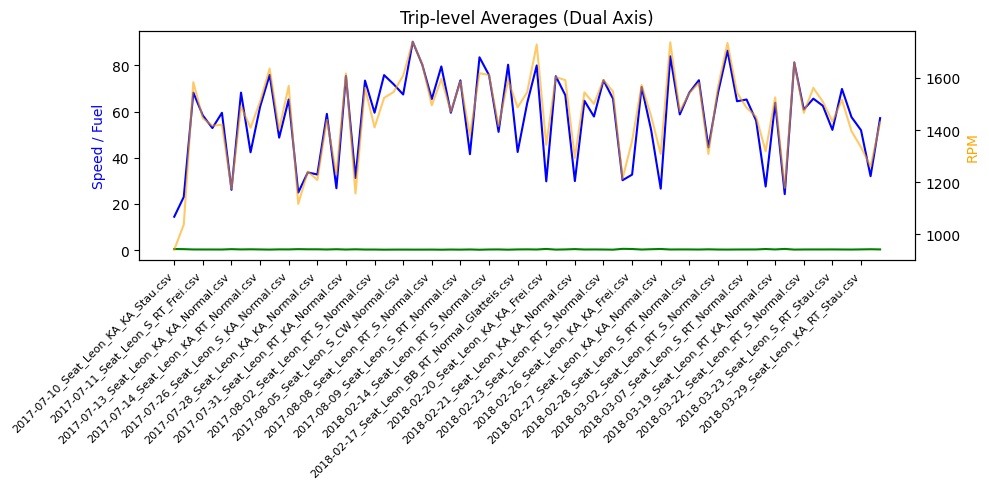

✅ Saved trip summary stats to ../data/trip_summary_stats.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cleaned combined dataset
df = pd.read_csv("../data/cleaned_kit_obd_combined.csv")

# Confirm structure
print(df.shape)
display(df.head())

#(a) Detect High RPM at Low Speed
def detect_high_rpm_low_speed(df, rpm_thresh=2500, speed_thresh=20):
    """Flag samples where engine RPM is high but speed is low."""
    return (df["RPM"] > rpm_thresh) & (df["Speed_kmh"] < speed_thresh)

#(b) Detect Long Idling Periods
def detect_long_idling(df, speed_thresh=2, duration_thresh=30):
    """
    Detect long idling: vehicle speed < threshold for >duration_thresh seconds.
    Assumes dt_s column exists (sampling interval).
    """
    df = df.copy()
    df["idle"] = df["Speed_kmh"] < speed_thresh
    df["idle_block"] = (df["idle"] != df["idle"].shift()).cumsum()

    idle_durations = (
        df.groupby("idle_block")["dt_s"].sum().reset_index(name="idle_duration")
    )
    long_idle_blocks = idle_durations[idle_durations["idle_duration"] > duration_thresh]["idle_block"]
    df["long_idle"] = df["idle_block"].isin(long_idle_blocks)
    return df

#(c) Detect Frequent Acceleration–Brake Cycles
def detect_accel_brake_cycles(df, accel_thresh=1.5, decel_thresh=-1.5):
    """
    Identify acceleration-braking cycles based on speed changes (m/s²).
    """
    df = df.copy()
    df["Speed_mps"] = df["Speed_kmh"] / 3.6
    df["accel_mps2"] = df["Speed_mps"].diff() / df["dt_s"]
    accel_events = (df["accel_mps2"] > accel_thresh).sum()
    brake_events = (df["accel_mps2"] < decel_thresh).sum()
    return accel_events, brake_events


#Generate Summary per Trip
summary = []

for trip, sub in df.groupby("source_file"):
    sub = sub.dropna(subset=["Speed_kmh", "RPM", "MAF_gps"])
    if len(sub) < 50:
        continue

    # Patterns
    high_rpm_low_speed_ratio = detect_high_rpm_low_speed(sub).mean()
    sub = detect_long_idling(sub)
    long_idle_ratio = sub["long_idle"].mean()

    accel_events, brake_events = detect_accel_brake_cycles(sub)

    # Trip-level summary
    summary.append({
        "Trip": trip,
        "Avg_Speed_kmh": sub["Speed_kmh"].mean(),
        "Avg_RPM": sub["RPM"].mean(),
        "Avg_Fuel_L/100km": sub["L_per_100km"].mean(),
        "HighRPM_LowSpeed_%": round(high_rpm_low_speed_ratio * 100, 2),
        "Long_Idle_%": round(long_idle_ratio * 100, 2),
        "Accel_Events": accel_events,
        "Brake_Events": brake_events,
    })

# Visualize Summary
trip_summary = pd.DataFrame(summary)
display(trip_summary.head())

# --- Improved Dual-Axis Plot ---
fig, ax1 = plt.subplots(figsize=(10, 5))

# Left axis for Speed & Fuel
ax1.plot(trip_summary["Trip"], trip_summary["Avg_Speed_kmh"], label="Avg Speed [km/h]", color="blue")
ax1.plot(trip_summary["Trip"], trip_summary["Avg_Fuel_L/100km"], label="Avg Fuel [L/100km]", color="green")
ax1.set_ylabel("Speed / Fuel", color="blue")

# Right axis for RPM
ax2 = ax1.twinx()
ax2.plot(trip_summary["Trip"], trip_summary["Avg_RPM"], label="Avg RPM", color="orange", alpha=0.6)
ax2.set_ylabel("RPM", color="orange")

# Formatting
ax1.set_title("Trip-level Averages (Dual Axis)")
ax1.set_xticks(range(0, len(trip_summary), max(1, len(trip_summary)//20)))
ax1.set_xticklabels(trip_summary["Trip"][::max(1, len(trip_summary)//20)], rotation=45, ha="right", fontsize=8)

fig.tight_layout()
plt.show()

trip_summary.to_csv("../data/trip_summary_stats.csv", index=False)
print("✅ Saved trip summary stats to ../data/trip_summary_stats.csv")

